In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# import os
# count=0
# for dirname, _, filenames in os.walk('/kaggle/input/preprocessed'):
#     for filename in filenames:
#         count+=1
# #         if '10003_' in filename:
# #         print(filename)
# #         if(count==100):
# #             break
# print(count)
# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import os
import shutil
import pathlib
import random
import datetime
import cv2

# Plotting libraries 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.signal import gaussian, convolve2d
import seaborn as sns

# Libraries for building the model
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPool2D, Dropout, Activation, GlobalAveragePooling2D, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.applications import DenseNet121, ResNet50, InceptionV3, Xception, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend
from tensorflow.keras.regularizers import l2, l1
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score, confusion_matrix

In [3]:
def image_preprocessing(img):
    # 1. Read the image
#     img = mpimg.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = img.astype(np.uint8)
    
    # 2. Extract the green channel of the image
    b, g, r = cv2.split(img)
    
    # 3.1. Apply CLAHE to intensify the green channel extracted image
    clh = cv2.createCLAHE(clipLimit=4.0)
    g = clh.apply(g)

    # g = amf(g, 3, 11)
    
    # 3.2. Convert enhanced image to grayscale
    merged_bgr_green_fused = cv2.merge((b, g, r))
    img_bw = cv2.cvtColor(merged_bgr_green_fused, cv2.COLOR_BGR2GRAY)
    
    # 4. Remove the isolated pixels using morphological cleaning operation.
    kernel1 = np.ones((1, 1), np.uint8)
    morph_open = cv2.morphologyEx(img_bw, cv2.MORPH_OPEN, kernel1)
    
    # 5. Extract blood vessels using mean-C thresholding.
    # thresh = cv2.adaptiveThreshold(morph_open, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 9, 5)
    thresh = cv2.adaptiveThreshold(morph_open, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 17, 4)
    # (T, thresh) = cv2.threshold(morph_open, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

    
    # 6. Applying morph_open operation
    kernel2 = np.ones((2, 2), np.uint8)
    morph_open2 = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel2)
    
    # 6. Stacking the image into 3 channels
    stacked_img = np.stack((morph_open2,)*3, axis=-1)
    
    return stacked_img.astype("float64")

In [4]:
df = pd.read_csv('/kaggle/input/dfwithpath/df.csv')
df=df.drop('Unnamed: 0',axis=1)

In [37]:
# os.mkdir('/kaggle/working/class0')
# os.mkdir('/kaggle/working/class1')
# os.mkdir('/kaggle/working/class2')
# os.mkdir('/kaggle/working/class3')
# os.mkdir('/kaggle/working/class4')

In [38]:
# # pro=[]
# # i=-1
# new_ls=[]
# for iname in df['image']:
# #     path = '/kaggle/input/eyepacspreprocess/eyepacs_preprocess/eyepacs_preprocess/'+iname+'.jpeg'
#   # i+=1
#   # if img + '.jpeg' in ls:
# #     path = '/kaggle/input/eyepacspreprocess/eyepacs_preprocess/eyepacs_preprocess/10003_left.jpeg'
#     if((df[df['image']==iname]['level']==0).bool()):
# #         os.chdir(r"/kaggle/working/class0")
#         c = 'class0'
#     elif((df[df['image']==iname]['level']==1).bool()):
# #         os.chdir(r"/kaggle/working/class1")
#         c = 'class1'
#     elif((df[df['image']==iname]['level']==2).bool()):
# #         os.chdir(r"/kaggle/working/class2")
#         c = 'class2'
#     elif((df[df['image']==iname]['level']==3).bool()):
# #         os.chdir(r"/kaggle/working/class3")
#         c = 'class3'
#     else:
#         c = 'class4'
# #         os.chdir(r"/kaggle/working/class4")
# #     img = mpimg.imread(path)
# #     pro = image_preprocessing(img)
#     filename = iname+'p.jpeg'
# # filename = os.path.basename(p)
# # plt.imshow(pro.astype("uint8"), cmap="gray");
# #     cv2.imwrite(filename, pro)
#     new_path = '/kaggle/input/preprocessed/'+c+'/'+filename
#     new_ls.append(new_path)
# df['new_path'] = new_ls
# # plt.imshow(img)

In [39]:
# plt.imshow(mpimg.imread('/kaggle/working/752_rightp.jpeg'))

In [5]:
df=df.drop("image",axis=1)

In [75]:
# level = df['level']
# df=df.drop('level',axis=1)
# df['level']=level

In [78]:
# from imblearn.under_sampling import RandomUnderSampler
# undersample = RandomUnderSampler(sampling_strategy={0:6000,1:2438,2:5288,3:872,4:708})

In [79]:
# X = df.iloc[:,:-1]
# y = df.iloc[:,-1]
# X_over, y_over = undersample.fit_resample(X, y)

In [80]:
# X_over

,image,new_path
0,36637_right,/kaggle/input/preprocessed/class0/36637_rightp...
1,39891_left,/kaggle/input/preprocessed/class0/39891_leftp....
2,44325_left,/kaggle/input/preprocessed/class0/44325_leftp....
3,22647_right,/kaggle/input/preprocessed/class0/22647_rightp...
4,37406_right,/kaggle/input/preprocessed/class0/37406_rightp...
...,...,...
15301,36640_right,/kaggle/input/preprocessed/class4/36640_rightp...
15302,40819_left,/kaggle/input/preprocessed/class4/40819_leftp....
15303,12014_right,/kaggle/input/preprocessed/class4/12014_rightp...
15304,17925_left,/kaggle/input/preprocessed/class4/17925_leftp....


In [81]:
# y_over

0        0
1        0
2        0
3        0
4        0
        ..
15301    4
15302    4
15303    4
15304    4
15305    4
Name: level, Length: 15306, dtype: int64

In [82]:
# df=pd.DataFrame()

In [83]:
# df["path"]=X_over["new_path"]

In [84]:
# df["level"]=y_over

In [6]:
df["level"].value_counts()

0    25802
2     5288
1     2438
3      872
4      708
Name: level, dtype: int64

In [16]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Create an ImageDataGenerator object with the desired data augmentation settings
# data_generator = ImageDataGenerator(
#     rotation_range=20,
# #     width_shift_range=0.2,
# #     height_shift_range=0.2,
# #     shear_range=0.2,
# #     zoom_range=0.2,
# #     horizontal_flip=True,
#     fill_mode='nearest'
# )

# # # Load the image data from a directory
# image_data = data_generator.flow_from_directory(
#     '/kaggle/input/preprocessed',
#     target_size=(224, 224),
#     batch_size=1,
#     class_mode='categorical',
#     shuffle=True,
# )
# class_dictionary = image_data.class_indices
# #---create a dictionary of labels---
# class_dictionary = { value:key for key,value in
#     class_dictionary.items()}
# #---convert the dictionary to a list---
# class_list = [value for _,value in class_dictionary.items()]
# print(class_list)
# image_batch = image_data.next()    
#     #---get the number of images returned---
# images_count = image_batch[0].shape[0]
# # # Fit the data generator to the image data and generate augmented images
# # data_generator.fit(image_data)
# # augmented_data = data_generator.flow(image_data[0][0], image_data[0][1], batch_size=32, shuffle=True)


Found 0 images belonging to 0 classes.
[]


In [11]:
!pip install Augmentor

In [ ]:
# import Augmentor

# # Define augmentation pipelines
# p4 = Augmentor.Pipeline("/kaggle/input/preprocessed/class4")
# # Initialised with 100 images found in selected directory.
# # p2 = Augmentor.Pipeline("/path/to/images2")
# # Initialised with 100 images found in selected directory.

# # Define different augmentations depending on the pipeline
# p4.rotate(probability=0.3, max_left_rotation=10, max_right_rotation=10)
# # First, we add a horizontal flip operation to the pipeline:
# p4.flip_left_right(probability=0.3)
# p4.random_color(probability=0.5, min_factor=0.4, max_factor=0.9)
# p4.random_contrast(probability=0.5, min_factor=0.9, max_factor=1.4)
# p4.random_distortion(probability=0.5, grid_width=7, grid_height=8, magnitude=9)
# p4.zoom(probability=0.7, min_factor=1.1, max_factor=1.25)
# p4.shear(probability=0.3, max_shear_left=0.2, max_shear_right=0.2)
# # Now we add a vertical flip operation to the pipeline:
# # p.flip_top_bottom(probability=0.8)

# # p2.rotate(probability=0.1, max_left_rotation=0, max_right_rotation=90)

# # Augment images
# p4.sample(1000)
# # p2.sample(10000)

In [15]:
# images_count

1

In [8]:
df["level"] = df["level"].astype(str)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35108 entries, 0 to 35107
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   level     35108 non-null  object
 1   new_path  35108 non-null  object
dtypes: object(2)
memory usage: 548.7+ KB


In [9]:
import cv2

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)


In [9]:
train.shape

(28086, 2)

In [11]:
HEIGHT=320
WIDTH=320
BATCH_SIZE=8
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2,
                                 horizontal_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/kaggle/input/preprocessed/",
    x_col="new_path",
    y_col="level",
    batch_size=12,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/kaggle/input/preprocessed/",
    x_col="new_path",
    y_col="level",
    batch_size=12,
    class_mode="categorical",    
    target_size=(HEIGHT, WIDTH),
    subset='validation')




Found 22469 validated image filenames belonging to 5 classes.
Found 5617 validated image filenames belonging to 5 classes.


In [11]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "/kaggle/input/preprocessed",
        x_col="new_path",
        target_size=(HEIGHT, WIDTH),
        batch_size=10,
        shuffle=False,
        class_mode=None)

Found 7022 validated image filenames.


In [ ]:
train_imgs, train_labels = next(train_generator)

val_imgs, val_labels = next(valid_generator)

In [ ]:
train_imgs.shape

In [ ]:
train_labels.shape

In [12]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 20
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 512
WIDTH = 512
CANAL = 3
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [13]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = keras.applications.ResNet50(weights='imagenet', 
                                       include_top=False,
                                       input_tensor=input_tensor)
    #base_model.load_weights('../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = tf.keras.Model(input_tensor, final_output)
    
    return model

In [14]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import Model

model = create_model(input_shape=(320, 320, 3), n_out=5)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

metric_list = ["accuracy"]
optimizer = keras.optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 326, 326, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 160, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [15]:
STEP_SIZE_TRAIN = train_generator.n//12
STEP_SIZE_VALID = valid_generator.n//12
model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/2
1872/1872 [==============================] - 354s 181ms/step - loss: 0.9855 - accuracy: 0.7211 - val_loss: 0.8547 - val_accuracy: 0.7361
Epoch 2/2
1872/1872 [==============================] - 206s 110ms/step - loss: 0.9005 - accuracy: 0.7352 - val_loss: 0.8888 - val_accuracy: 0.7363


{'loss': [0.9854861497879028, 0.9005054235458374],
 'accuracy': [0.721066951751709, 0.7352273464202881],
 'val_loss': [0.8546798825263977, 0.8888031840324402],
 'val_accuracy': [0.7361111044883728, 0.7362892031669617]}

In [19]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau


for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 326, 326, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 160, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [20]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/20
1872/1872 [==============================] - 589s 292ms/step - loss: 0.9220 - accuracy: 0.7346 - val_loss: 0.8704 - val_accuracy: 0.7361 - lr: 0.0010
Epoch 2/20
1872/1872 [==============================] - 550s 294ms/step - loss: 0.8940 - accuracy: 0.7352 - val_loss: 1.4250 - val_accuracy: 0.7361 - lr: 0.0010
Epoch 3/20
1872/1872 [==============================] - 548s 292ms/step - loss: 0.8977 - accuracy: 0.7350 - val_loss: 0.9068 - val_accuracy: 0.7361 - lr: 0.0010
Epoch 4/20
1872/1872 [==============================] - ETA: 0s - loss: 0.8794 - accuracy: 0.7354
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1872/1872 [==============================] - 547s 292ms/step - loss: 0.8794 - accuracy: 0.7354 - val_loss: 2.4965 - val_accuracy: 0.7361 - lr: 0.0010
Epoch 5/20
1872/1872 [==============================] - 547s 292ms/step - loss: 0.8766 - accuracy: 0.7354 - val_loss: 0.9116 - val_accuracy: 0.7361 - lr: 5.0000e-04
Epoch 6/20
1872/1872 [======

In [45]:

train_datagen=ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2,
                                 horizontal_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=None,
    x_col="new_path",
    y_col="level",
    batch_size=8,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=None,
    x_col="new_path",
    y_col="level",
    batch_size=8,
    class_mode="categorical",    
    target_size=(HEIGHT, WIDTH),
    subset='validation')

# test_datagen = ImageDataGenerator(rescale=1./255)

# test_generator = test_datagen.flow_from_dataframe(  
#         dataframe=test,
#         directory = none,
#         x_col="id_code",
#         target_size=(HEIGHT, WIDTH),
#         batch_size=1,
#         shuffle=False,
#         class_mode=None)

Found 28087 validated image filenames belonging to 5 classes.
Found 7021 validated image filenames belonging to 5 classes.


In [114]:
X,y=valid_generator.next()

In [17]:
NUM_CLASSES = 5

# Fixed for Cats & Dogs color images
CHANNELS = 3

IMAGE_RESIZE = 320
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [18]:
from  keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

In [19]:
resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'


In [20]:
model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [21]:
input_shape = (None, 320, 320, 3)
model.build(input_shape)
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________


In [22]:
import tensorflow as tf
from tensorflow.python.keras import optimizers

model.compile(optimizer = "adam", loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [23]:
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(valid_generator))


(100, 2809, 100, 703)

In [48]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [27]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = 100,
        validation_data=valid_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION
        
)


Epoch 1/100
10/10 [==============================] - 2s 228ms/step - loss: 0.9409 - accuracy: 0.7250 - val_loss: 2.4678 - val_accuracy: 0.0500
Epoch 2/100
10/10 [==============================] - 2s 225ms/step - loss: 0.9275 - accuracy: 0.7000 - val_loss: 2.3377 - val_accuracy: 0.1000
Epoch 3/100
10/10 [==============================] - 2s 244ms/step - loss: 0.7953 - accuracy: 0.7625 - val_loss: 2.3313 - val_accuracy: 0.0750
Epoch 4/100
10/10 [==============================] - 2s 225ms/step - loss: 1.0270 - accuracy: 0.6625 - val_loss: 2.2935 - val_accuracy: 0.0500
Epoch 5/100
10/10 [==============================] - 2s 226ms/step - loss: 1.0550 - accuracy: 0.6125 - val_loss: 1.9243 - val_accuracy: 0.0750
Epoch 6/100
10/10 [==============================] - 2s 231ms/step - loss: 1.3681 - accuracy: 0.4875 - val_loss: 2.3611 - val_accuracy: 0.0625
Epoch 7/100
10/10 [==============================] - 2s 233ms/step - loss: 1.0163 - accuracy: 0.7000 - val_loss: 2.0200 - val_accuracy: 0.0500

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


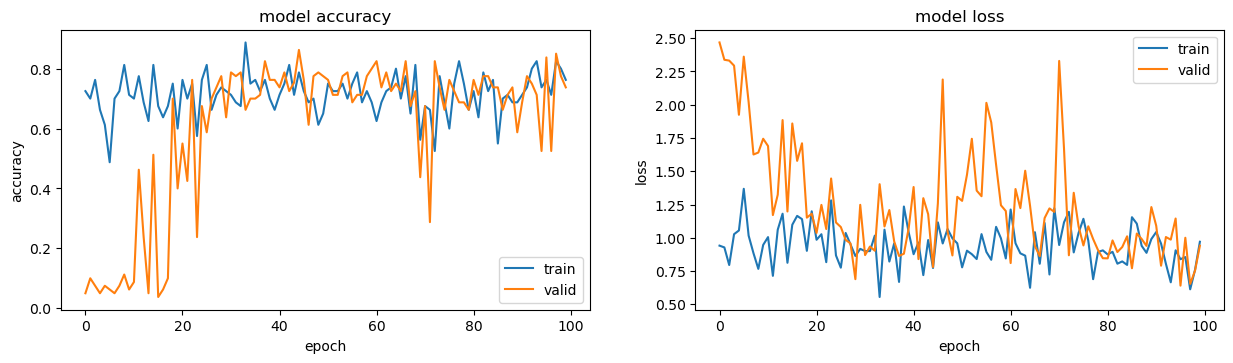

In [28]:
print(fit_history.history.keys())

plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()



In [29]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "/kaggle/input/preprocessed",
        x_col="new_path",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 7022 validated image filenames.


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2022: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


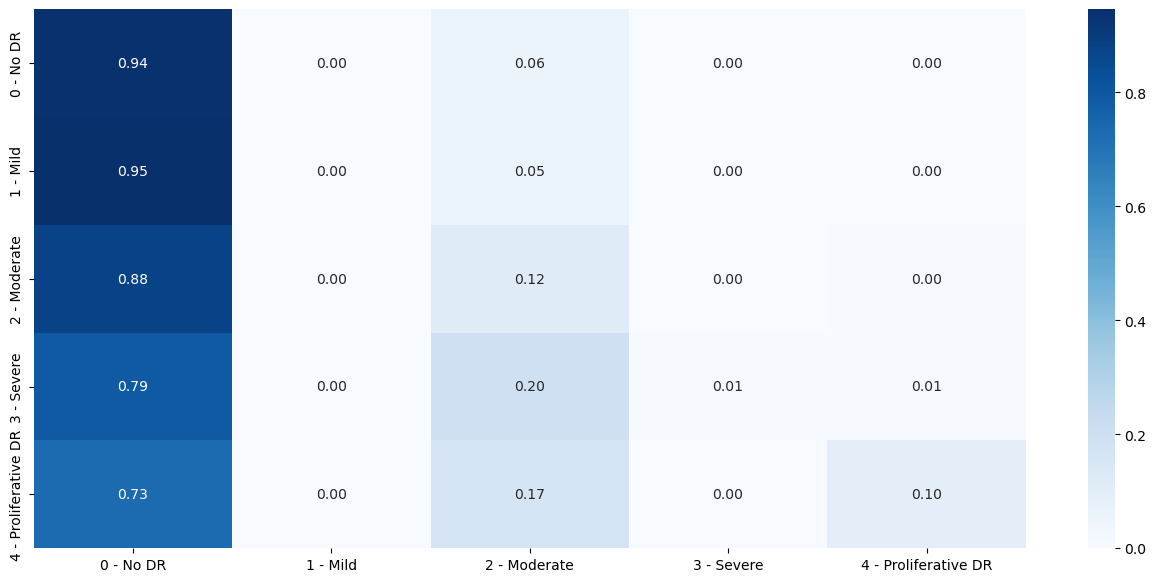

In [30]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(test['level'].astype('int'), train_preds)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(y_train_new),
                                                 y=y_train_new)
class_weights = dict(enumerate(class_weights))

In [31]:
print(classification_report(test['level'].astype('int'), train_preds))


              precision    recall  f1-score   support

           0       0.74      0.94      0.83      5118
           1       0.00      0.00      0.00       481
           2       0.25      0.12      0.16      1094
           3       0.50      0.01      0.01       168
           4       0.48      0.10      0.16       161

    accuracy                           0.71      7022
   macro avg       0.40      0.23      0.23      7022
weighted avg       0.60      0.71      0.63      7022



In [74]:



test_generator = train_datagen.flow_from_directory(
    directory = '/kaggle/input/preprocessed',
    target_size = (224, 224),
    batch_size = BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)

Found 35108 images belonging to 5 classes.


In [104]:
pred = model.predict_generator(valid_generator, steps = len(valid_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2022: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


878/878 [==============================] - 53s 60ms/step


In [105]:
predicted_class_indices

array([0, 0, 0, ..., 0, 0, 0])

In [110]:
valid_generator

In [111]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
cf =confusion_matrix(valid_generator,predicted_class_indices)
print("The classification metrics is  :  ",cf)

ValueError: Found input variables with inconsistent numbers of samples: [878, 7021]

In [90]:
from keras.applications.inception_v3 import InceptionV3

In [91]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import os
import gc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import psutil
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import ceil
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Flatten, Dense
from keras.models import Model
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Input
from keras import backend as K

In [92]:
input_tensor = Input(shape = (320, 320, 3))

# create the base pre-trained model
base_model = InceptionV3(weights=None, include_top=False, input_tensor=input_tensor)

# add a global spatial average pooling layer
x = base_model.output
output = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# and a logistic layer -- let's say we have 200 classes
predictions = Dense(5, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

for layer in model.layers:
    layer.trainable = True
    
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 159, 159, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_95 (BatchN  (None, 159, 159, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [93]:
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(learning_rate=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [94]:
NUB_TRAIN_STEPS = train_generator.n // train_generator.batch_size
NUB_VALID_STEPS = valid_generator.n // valid_generator.batch_size

NUB_TRAIN_STEPS, NUB_VALID_STEPS

(1530, 382)

In [95]:
eraly_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')
# Reducing the Learning Rate if result is not improving. 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=2, factor=0.1, min_lr=1e-6, mode='auto',
                              verbose=1)

In [96]:
history = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=2000,
                                     validation_data=valid_generator,
                                     validation_steps=NUB_VALID_STEPS,
                                     epochs=1,
                                     #                            shuffle=True,  
                                     callbacks=[eraly_stop, reduce_lr],
                                     verbose=1)
gc.collect()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


2000/2000 [==============================] - 291s 142ms/step - loss: 1.3860 - accuracy: 0.4226 - val_loss: 1.2398 - val_accuracy: 0.0219 - lr: 0.0100


27291

In [ ]:
y_train_new = np.argmax(valid_generator, axis=1)